## Deploy Groupwise Incident Analysis & Prediction Model Package from AWS Marketplace 


This solution provides compositional analysis and predicts the number of incidents pertaining to each ticket group. The insights around incident distribution helps in proper capacity planning, resulting in efficient resource utilization. The Machine Learning based algorithm predicts incident volume at group/category level. Volume analysis and prediction is based on historical incident data. Incidents can be grouped based on nature of incident, criticality and/or severity. The solution utilizes both contextual and temporal features of incidents for prediction.

This sample notebook shows you how to deploy Groupwise Incident Analysis & Prediction using Amazon SageMaker.

> **Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.

#### Pre-requisites:
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. To deploy this ML model successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to Groupwise Incident Analysis & Prediction. If so, skip step: [Subscribe to the model package](#1.-Subscribe-to-the-model-package)

#### Contents:
1. [Subscribe to the model package](#1.-Subscribe-to-the-model-package)
2. [Create an endpoint and perform real-time inference](#2.-Create-an-endpoint-and-perform-real-time-inference)
   1. [Create an endpoint](#A.-Create-an-endpoint)
   2. [Create input payload](#B.-Create-input-payload)
   3. [Perform real-time inference](#C.-Perform-real-time-inference)
   4. [Output Result](#D.-Output-Result)
   5. [Delete the endpoint](#E.-Delete-the-endpoint)
3. [Perform batch inference](#3.-Perform-batch-inference) 
4. [Clean-up](#4.-Clean-up)
    1. [Delete the model](#A.-Delete-the-model)
    2. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))
    

#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

### 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page Groupwise Incident Analysis & Prediction
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

In [1]:
model_package_arn='arn:aws:sagemaker:us-east-2:786796469737:model-package/mphasis-deepinsights-groupwise-incident-analysis'

In [2]:
import pandas as pd
import json
import os
import boto3
import uuid
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
from IPython.display import Image
from PIL import Image as ImageEdit
from zipfile import ZipFile

No handlers could be found for logger "sagemaker"


In [3]:
role = get_execution_role()

sagemaker_session = sage.Session()

bucket=sagemaker_session.default_bucket()
bucket

'sagemaker-us-east-2-786796469737'

### 2. Create an endpoint and perform real-time inference

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [4]:
model_name='mphasis-deepinsights-groupwise-incident-analysis'

content_type='application/zip'

real_time_inference_instance_type='ml.m5.xlarge'
batch_transform_inference_instance_type='ml.m5.large'

#### A. Create an endpoint

In [5]:
def predict_wrapper(endpoint, session):
    return sage.RealTimePredictor(endpoint, session,content_type=content_type)

#create a deployable model from the model package.

model = ModelPackage(role=role,
                    model_package_arn=model_package_arn,
                    sagemaker_session=sagemaker_session,
                    predictor_cls=predict_wrapper)

In [6]:
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name)

-----------!

Once endpoint has been created, you would be able to perform real-time inference.

#### B. Create input payload

#### Input Format & Instructions

The solution needs <b>“.zip”</b> file containing the following two files in CSV (UTF-8 encoded) format containing requisite fields
<ol><li><b>Train.csv</b> : Fields are as follows:
    <ul><li><b>Date:</b> Date (MM/DD/YYYY) when Incident occurred.
        <li><b>Group_Name:</b> Group to which application belongs for which incident notified.
        <li><b>Application_Name:</b> The application in which error notified.            
    </ul>
    <li><b>Predict.csv</b> : Fields are as follows:
     <ul><li><b>Date:</b> Any future date (MM/DD/YYYY) for which the forecasting is needed.
     <li><b>Group_Name:</b> Group to which application belongs for which number of incidents needed to be forecasted.
     <li><b>Application_Name:</b> Application for which number of incidents needed to be forecasted.
     </ul>
</ol> 
<b>NOTE:</b> Please make sure (Group_Name, Application_Name) combination in Test.csv should also be there in Train.csv



In [9]:
file_path = os.getcwd()
file_name = 'data/input/Input.zip'

file_object = open(file_name,'rb')
z = ZipFile(file_object)
file_names = []
for name in z.namelist():
    z.extract(name,file_path)
    file_names.append(name)
file_object.close()
print(file_names)

['Predict.csv', 'Train.csv']


In [12]:
train_df = pd.read_csv('Train.csv')
train_df.head()

,Date,Group_Name,Application_Name
0,6/27/2017,grp_33,app_128
1,10/10/2017,grp_33,app_128
2,7/12/2018,grp_33,app_128
3,4/20/2017,grp_33,app_128
4,6/14/2017,grp_33,app_128


In [13]:
predict_df = pd.read_csv('Predict.csv')
predict_df.head()

,Date,Group_Name,Application_Name
0,12/27/2017,grp_33,app_128
1,1/31/2018,grp_33,app_128
2,4/3/2018,grp_33,app_128
3,8/8/2017,grp_33,app_128
4,8/2/2017,grp_33,app_128


In [10]:
output_file_name = 'data/output/output.zip'

#### C. Perform real-time inference

In [11]:
!aws sagemaker-runtime invoke-endpoint \
    --endpoint-name $model_name \
    --body fileb://$file_name \
    --content-type $content_type \
    --region $sagemaker_session.boto_region_name \
    $output_file_name

{
    "InvokedProductionVariant": "AllTraffic", 
    "ContentType": "application/zip"
}


#### D. Output Result
Output is in the form of <b>‘.zip’</b> file which contains two files

<ol><li><b>Total_incidents_by_month.png</b> : This file contains actual tickets distribution.</li>
    <li><b>Results.csv</b> : This file contains result of forecasting with following 4 fields:
     <ul><li><b>Date:</b> Any future date (MM/DD/YYYY) for which the forecasting is needed. (since prediction is on daily basis)
     <li><b>Group_Name:</b> Group to which application belongs for which number incidents needed to be forecasted.
     <li><b>Application_Name:</b> Application for which number of incidents needed to be forecasted.
     <li><b>Incidents:</b> The total number of incidents for “Group_Name - Application_Name” combination that occur on the corresponding date.
     </ul>
</ol> 

In [15]:
with ZipFile('data/output/output.zip', 'r') as zipObj:
    zipObj.extractall()

In [16]:
Output = pd.read_csv('Results.csv')

In [17]:
Output

,Date,Group_Name,Application_Name,Incidents
0,2017-12-27,grp_33,app_128,2.0
1,2018-01-31,grp_33,app_128,2.0
2,2018-04-03,grp_33,app_128,2.0
3,2017-08-08,grp_33,app_128,2.0
4,2017-08-02,grp_33,app_128,2.0
5,2018-01-05,grp_33,app_128,2.0
6,2017-04-03,grp_33,app_128,2.0
7,2017-04-28,grp_33,app_128,2.0
8,2017-12-30,grp_33,app_128,1.0
9,2018-01-11,grp_33,app_128,2.0


In [19]:
Total_incidents_by_month = Image(filename = 'Total_incidents_by_month.png')

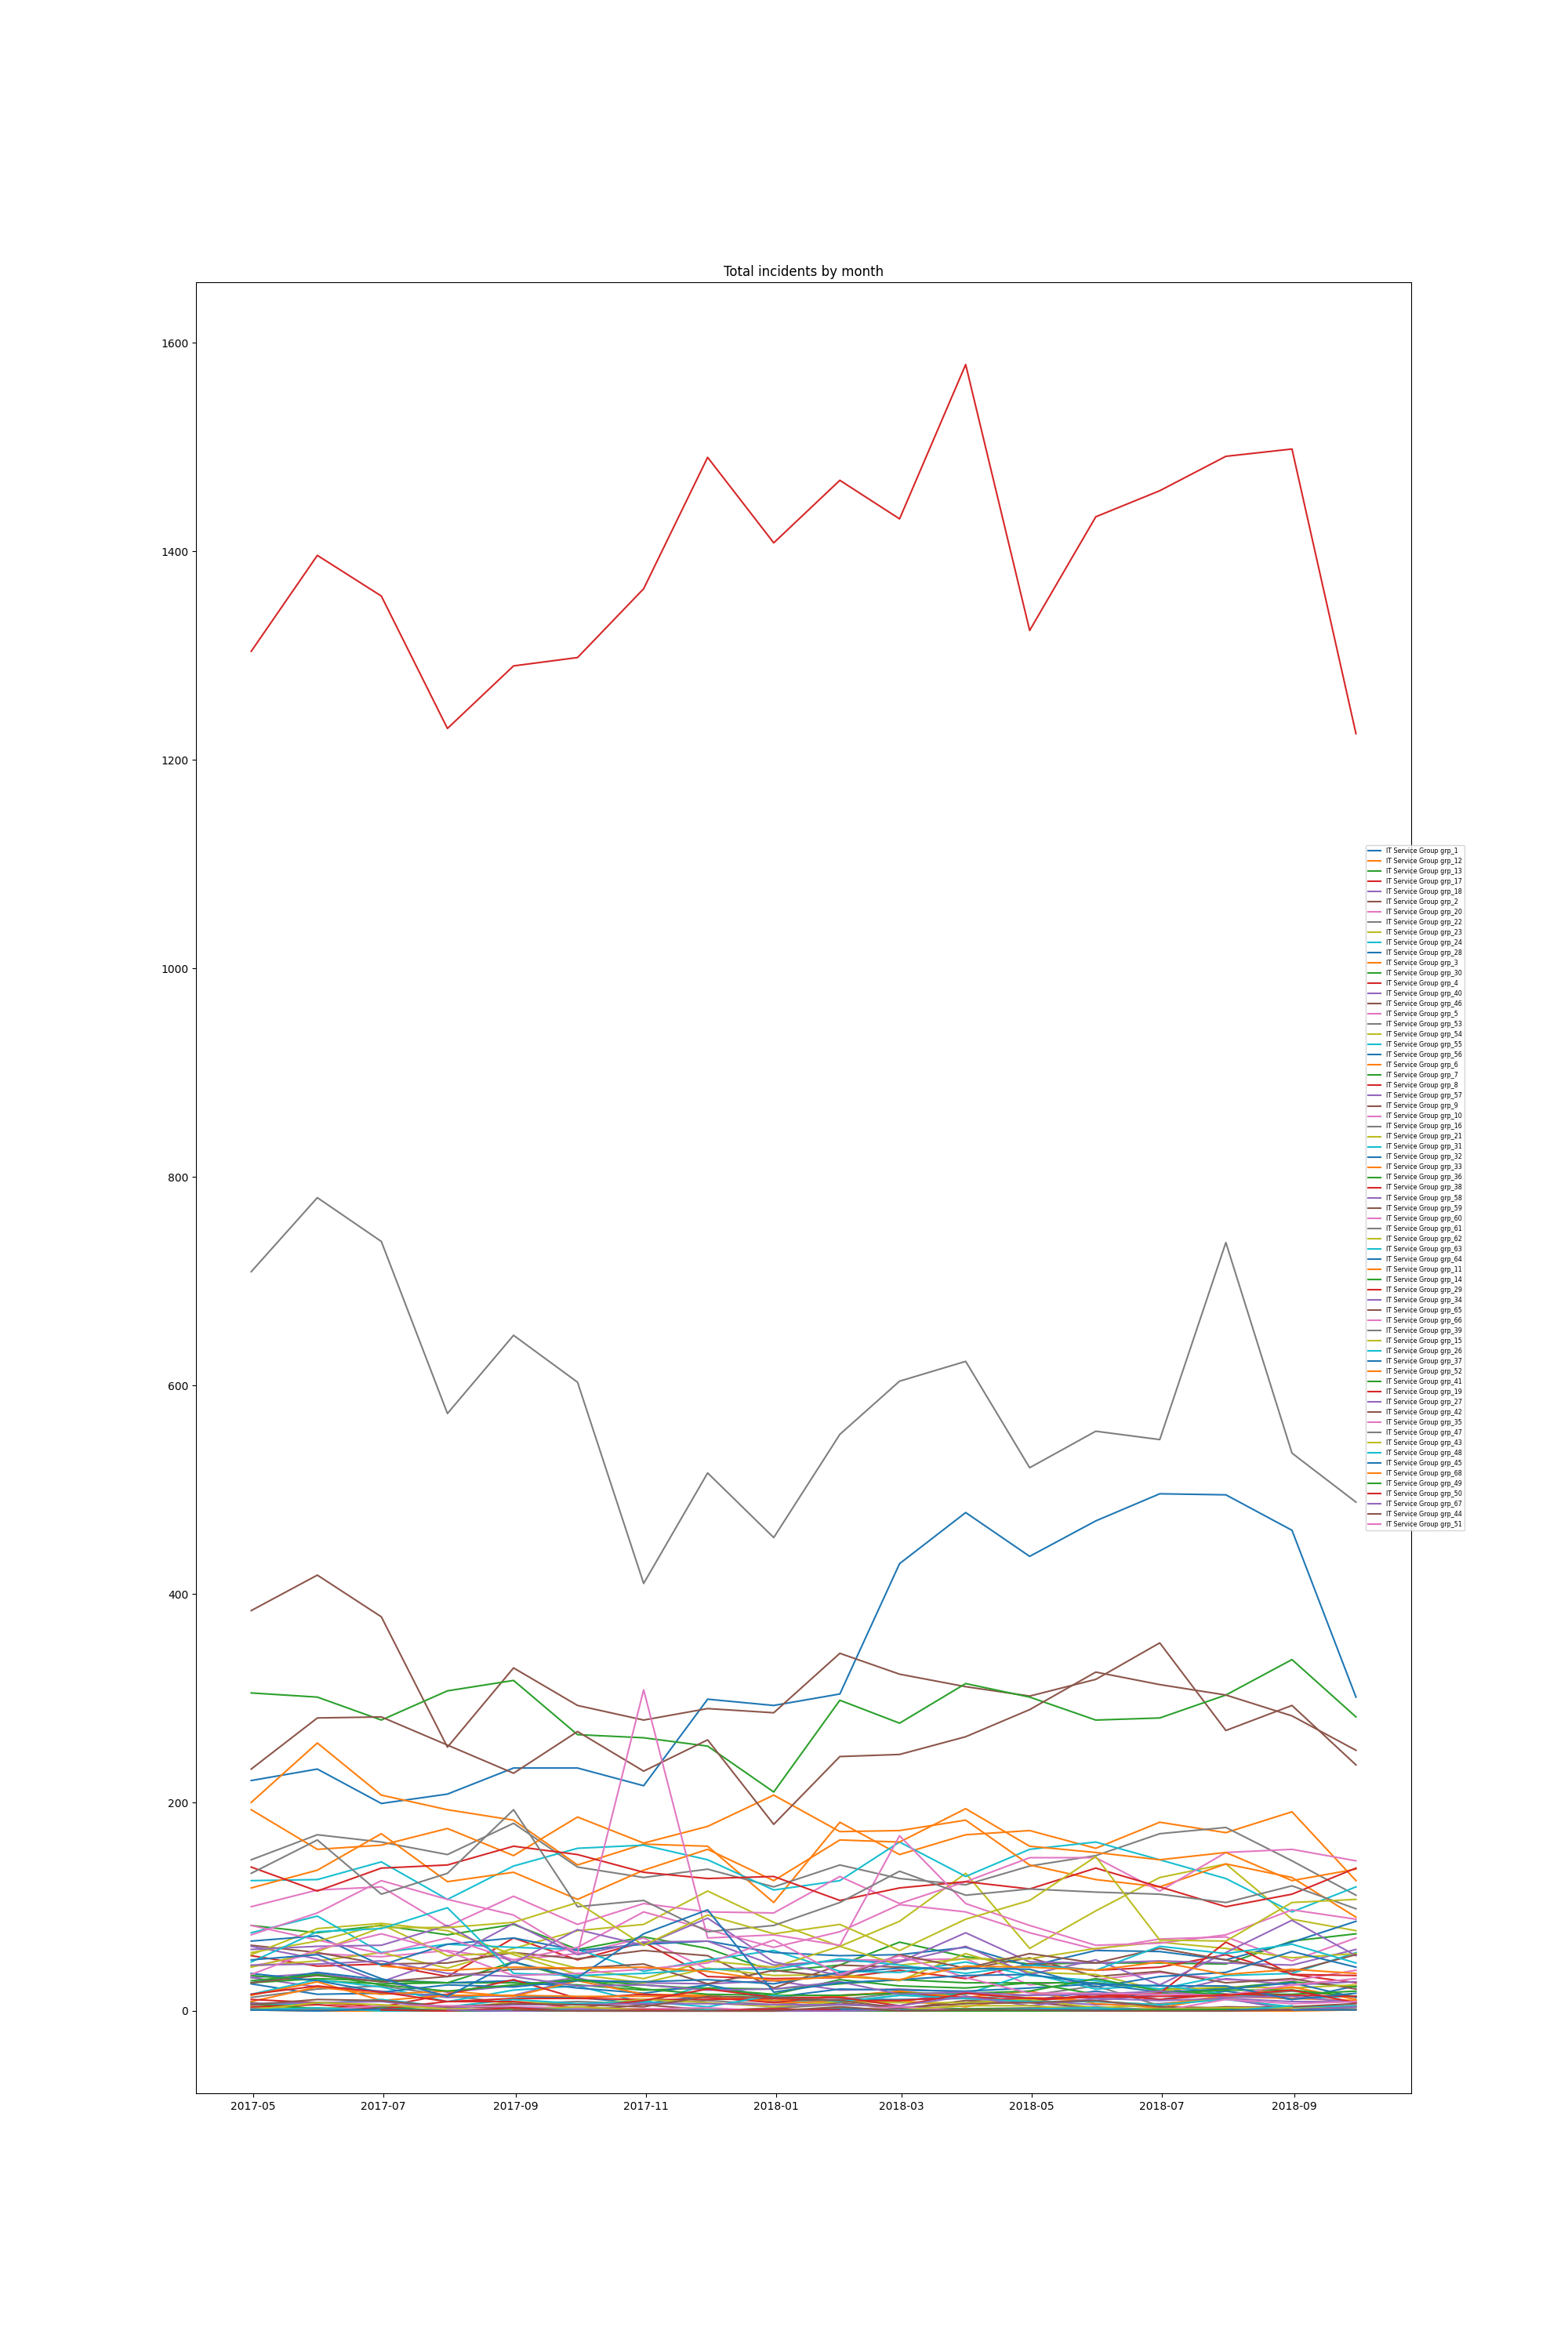

In [20]:
Total_incidents_by_month

#### E. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [ ]:
predictor=sage.predictor.Predictor(model_name, sagemaker_session,content_type)
predictor.delete_endpoint(delete_endpoint_config=True)

### 3. Perform batch inference

In this section, you will perform batch inference using multiple input payloads together. If you are not familiar with batch transform, and want to learn more, see these links:
1. [How it works](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-batch-transform.html)
2. [How to run a batch transform job](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html)

In [22]:
#upload the batch-transform job input files to S3
transform_input_folder = "data/input/Input.zip"
transform_input = sagemaker_session.upload_data(transform_input_folder, key_prefix=model_name) 
print("Transform input uploaded to " + transform_input)

Transform input uploaded to s3://sagemaker-us-east-2-786796469737/mphasis-deepinsights-groupwise-incident-analysis/Input.zip


In [ ]:
#Run the batch-transform job
transformer = model.transformer(1, batch_transform_inference_instance_type)
transformer.transform(transform_input, content_type=content_type)
transformer.wait()

In [24]:
#output is available on following path
transformer.output_path

's3://sagemaker-us-east-2-786796469737/mphasis-deepinsights-groupwise-incident-2021-03-08-09-21-45-239'

In [27]:
s3_conn = boto3.client("s3")
bucket_name="sagemaker-us-east-2-786796469737"
with open('./data/output/output.zip', 'wb') as f:
    s3_conn.download_fileobj(bucket_name, 'mphasis-deepinsights-groupwise-incident-2021-03-08-09-21-45-239'+'/Input.zip.out', f)
    print("Output file loaded from bucket")

Output file loaded from bucket


In [28]:
with ZipFile('data/output/output.zip', 'r') as zipObj:
    zipObj.extractall()

In [29]:
Output = pd.read_csv('Results.csv')

In [30]:
Output

,Date,Group_Name,Application_Name,Incidents
0,2017-12-27,grp_33,app_128,2.0
1,2018-01-31,grp_33,app_128,2.0
2,2018-04-03,grp_33,app_128,2.0
3,2017-08-08,grp_33,app_128,2.0
4,2017-08-02,grp_33,app_128,2.0
5,2018-01-05,grp_33,app_128,2.0
6,2017-04-03,grp_33,app_128,2.0
7,2017-04-28,grp_33,app_128,2.0
8,2017-12-30,grp_33,app_128,1.0
9,2018-01-11,grp_33,app_128,2.0


In [31]:
Total_incidents_by_month = Image(filename = 'Total_incidents_by_month.png')

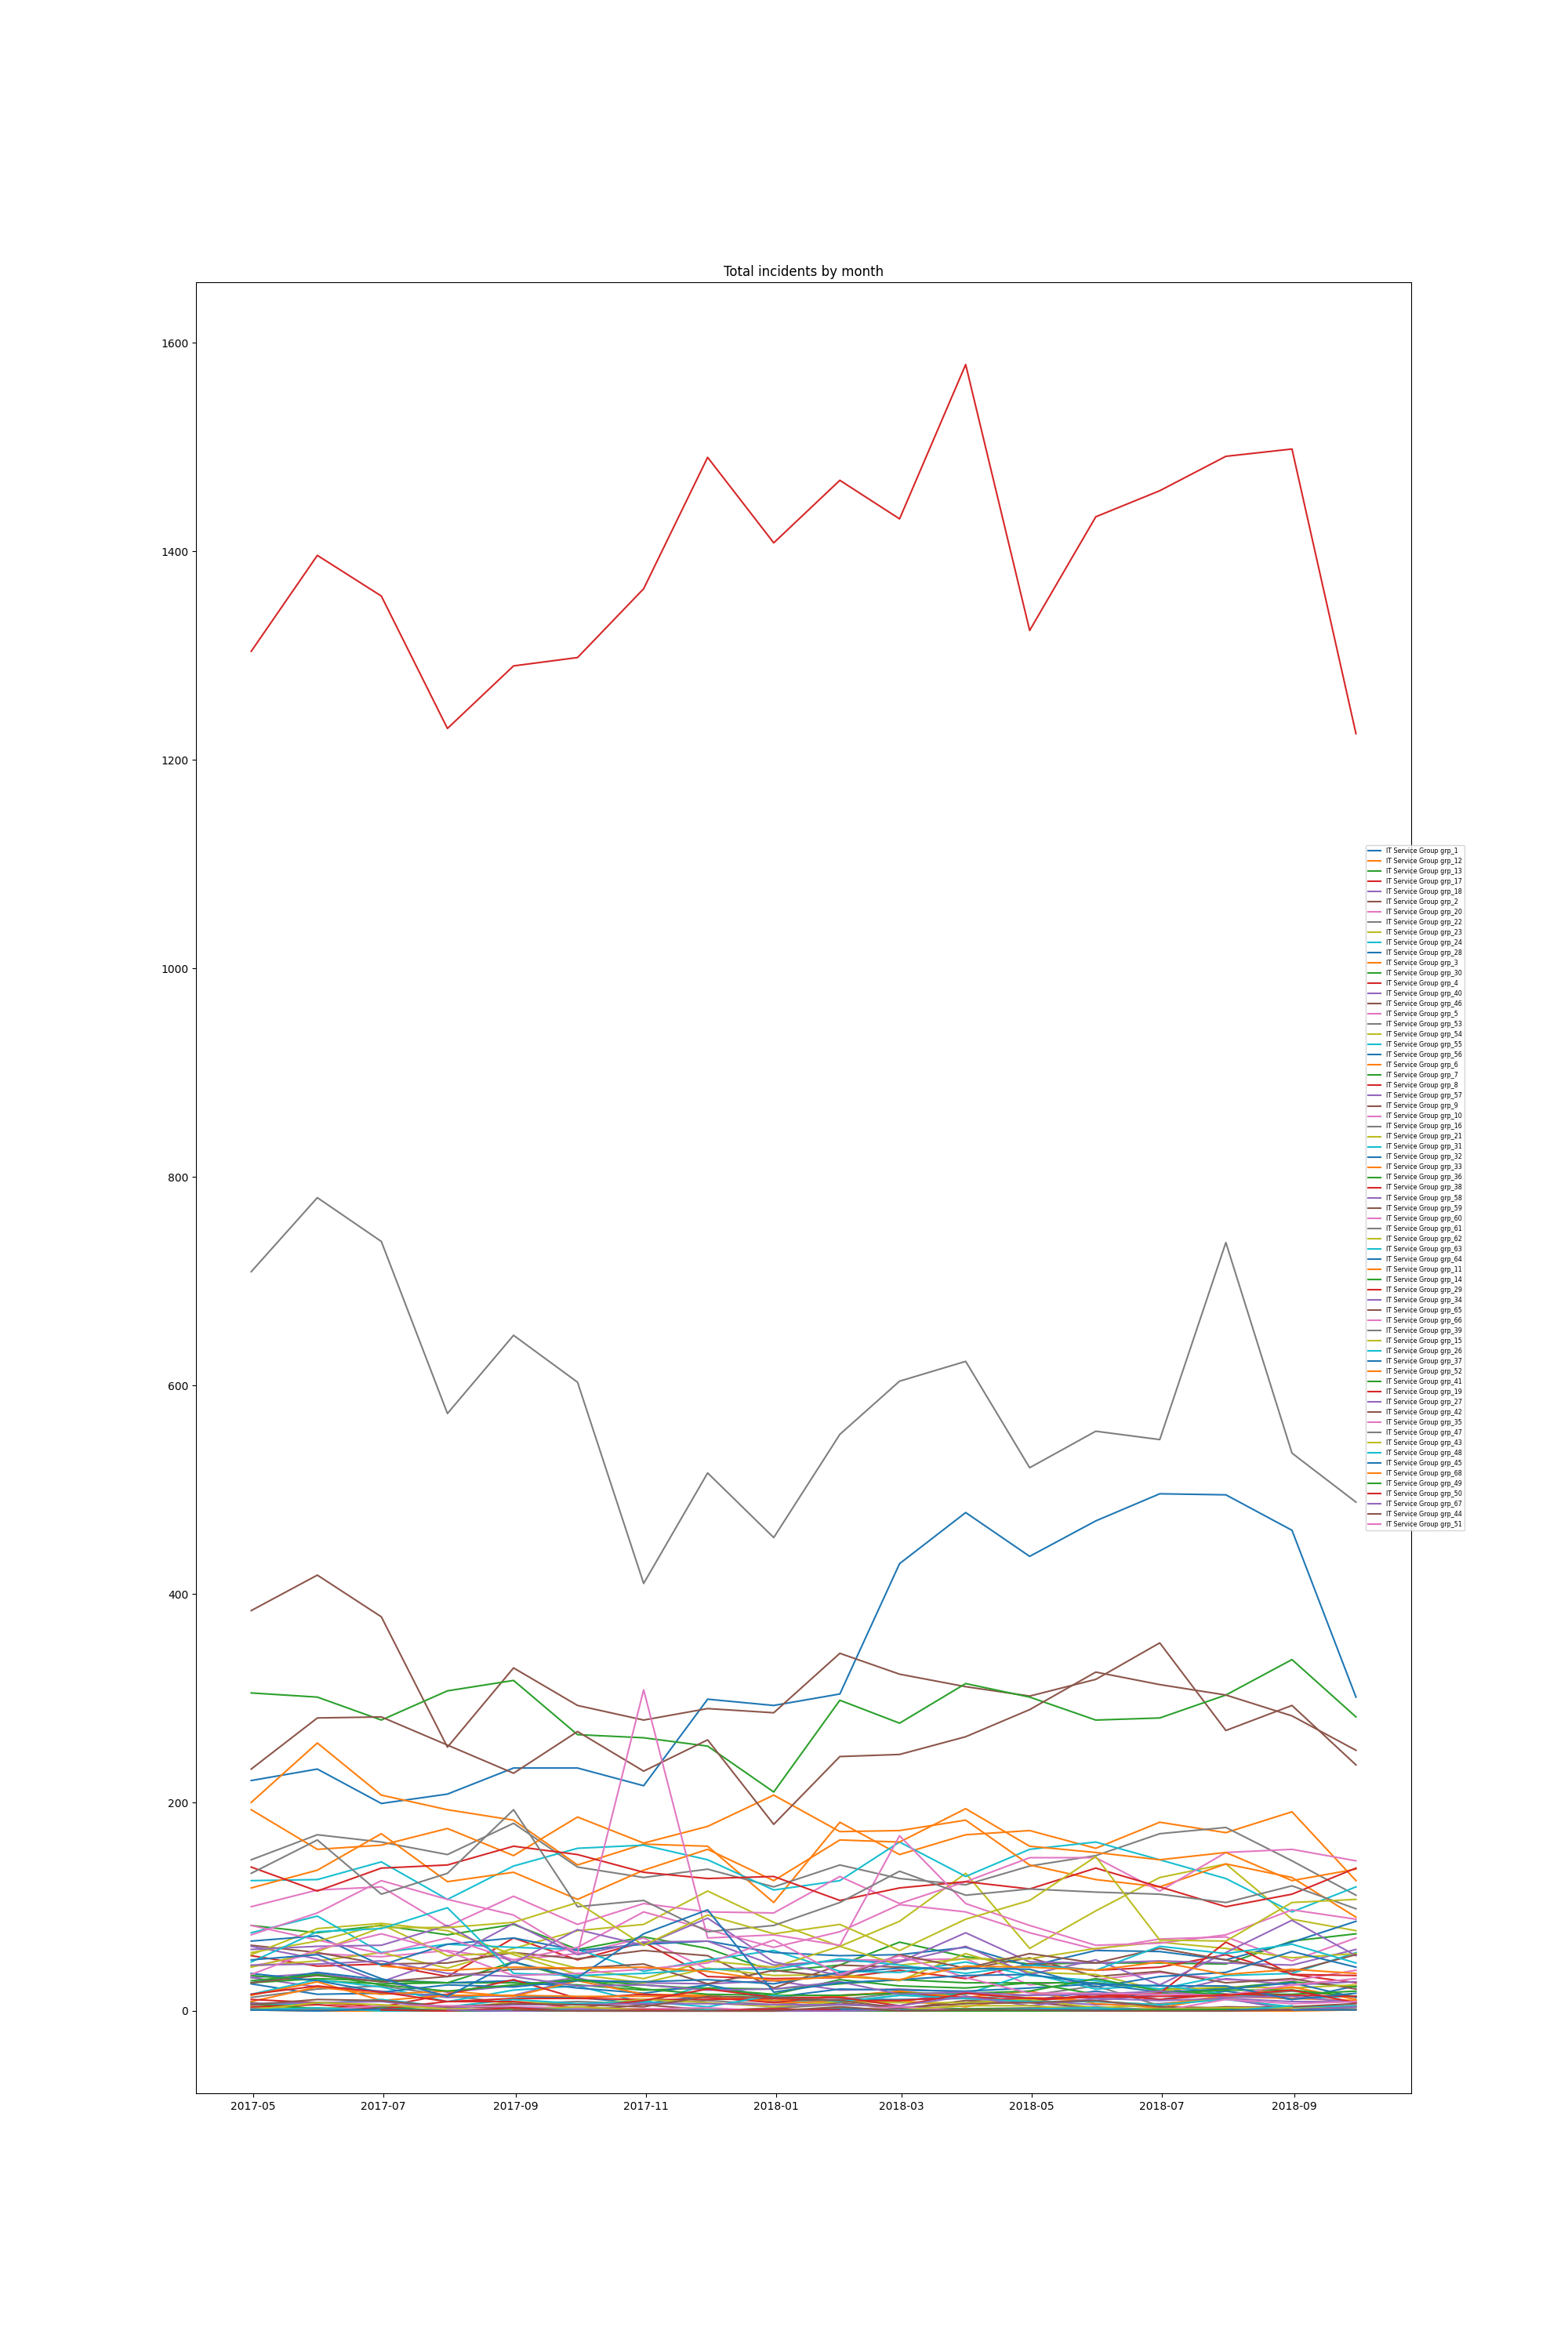

In [32]:
Total_incidents_by_month

### 4. Clean-up

#### A. Delete the model

In [33]:
model.delete_model()

#### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.